## Imports

In [2]:
import pickle
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import os.path
from decimal import Decimal

import copy
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import torch
import torch.onnx
import torch.utils.data as data
from sklearn.preprocessing import StandardScaler

In [3]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.manual_seed(42)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(torch.from_numpy(np.array(x)), torch.from_numpy(np.array(y))) for x, y in zip(in_data, target)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

In [28]:
file_pickled = open('data/train.pkl', 'rb')
file_unpickled = pickle.load(file_pickled)
file_pickled.close()

df_train = pd.DataFrame(file_unpickled)

file_pickled = open('data/test_no_target.pkl', 'rb')
file_unpickled = pickle.load(file_pickled)
file_pickled.close()

df_eval = pd.DataFrame(file_unpickled)

In [29]:
df_train

,0,1
0,"[-1.0, -1.0, -1.0, -1.0, 144.0, 144.0, 144.0, ...",0
1,"[-1.0, -1.0, 144.0, 144.0, 34.0, 0.0, 4.0, 2.0...",0
2,"[66.0, 100.0, 148.0, 148.0, 146.0, 64.0, 146.0...",0
3,"[147.0, 65.0, 64.0, 146.0, 8.0, 50.0, 160.0, 5...",0
4,"[144.0, 144.0, 144.0, 144.0, 144.0, 64.0, 64.0...",0
...,...,...
2934,"[144.0, 144.0, 144.0, 66.0, 82.0, 132.0, 8.0, ...",4
2935,"[32.0, 33.0, 162.0, 121.0, 68.0, 68.0, 120.0, ...",4
2936,"[33.0, 33.0, 33.0, 33.0, 78.0, 2.0, 68.0, 34.0...",4
2937,"[96.0, 96.0, 96.0, 96.0, 176.0, 176.0, 176.0, ...",4


In [30]:
df_eval

,0,1,2,3,4,5,6,7,8,9,...,8956,8957,8958,8959,8960,8961,8962,8963,8964,8965
0,0.0,0.0,0.0,0.0,88.0,88.0,88.0,88.0,69.0,145.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,2.0,18.0,50.0,82.0,1.0,1.0,82.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1.0,64.0,64.0,144.0,144.0,144.0,3.0,0.0,0.0,67.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,144.0,146.0,1.0,132.0,34.0,100.0,148.0,148.0,92.0,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,96.0,18.0,100.0,18.0,36.0,76.0,50.0,100.0,108.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098,112.0,112.0,0.0,0.0,0.0,159.0,190.0,12.0,92.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1099,112.0,112.0,112.0,112.0,124.0,32.0,32.0,32.0,124.0,112.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1100,176.0,176.0,66.0,146.0,124.0,190.0,77.0,185.0,157.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1101,32.0,32.0,32.0,32.0,33.0,78.0,92.0,33.0,33.0,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# df_train.iloc[:, 1] = df_train.iloc[:, 1].apply(lambda x: [1 if i == x else 0 for i in range(5)])

In [32]:
df_train_scaled = df_train.copy()
# df_list = np.concatenate(df_train_scaled[0])
# std = np.std(df_list)
# mean = np.mean(df_list)
# df_train_scaled[0] = df_train_scaled[0].apply(lambda list_x: [(x - mean) / std for x in list_x])
df_train_scaled

,0,1
0,"[-1.0, -1.0, -1.0, -1.0, 144.0, 144.0, 144.0, ...",0
1,"[-1.0, -1.0, 144.0, 144.0, 34.0, 0.0, 4.0, 2.0...",0
2,"[66.0, 100.0, 148.0, 148.0, 146.0, 64.0, 146.0...",0
3,"[147.0, 65.0, 64.0, 146.0, 8.0, 50.0, 160.0, 5...",0
4,"[144.0, 144.0, 144.0, 144.0, 144.0, 64.0, 64.0...",0
...,...,...
2934,"[144.0, 144.0, 144.0, 66.0, 82.0, 132.0, 8.0, ...",4
2935,"[32.0, 33.0, 162.0, 121.0, 68.0, 68.0, 120.0, ...",4
2936,"[33.0, 33.0, 33.0, 33.0, 78.0, 2.0, 68.0, 34.0...",4
2937,"[96.0, 96.0, 96.0, 96.0, 176.0, 176.0, 176.0, ...",4


In [33]:
df_eval_scaled = df_eval.copy()
# std = np.nanstd(df_eval_scaled.values)
# mean = np.nanmean(df_eval_scaled.values)
# df_eval_scaled = df_eval_scaled.apply(lambda x: (x - mean) / std)
df_eval_scaled

,0,1,2,3,4,5,6,7,8,9,...,8956,8957,8958,8959,8960,8961,8962,8963,8964,8965
0,0.0,0.0,0.0,0.0,88.0,88.0,88.0,88.0,69.0,145.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,2.0,18.0,50.0,82.0,1.0,1.0,82.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1.0,64.0,64.0,144.0,144.0,144.0,3.0,0.0,0.0,67.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,144.0,146.0,1.0,132.0,34.0,100.0,148.0,148.0,92.0,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,96.0,18.0,100.0,18.0,36.0,76.0,50.0,100.0,108.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098,112.0,112.0,0.0,0.0,0.0,159.0,190.0,12.0,92.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1099,112.0,112.0,112.0,112.0,124.0,32.0,32.0,32.0,124.0,112.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1100,176.0,176.0,66.0,146.0,124.0,190.0,77.0,185.0,157.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1101,32.0,32.0,32.0,32.0,33.0,78.0,92.0,33.0,33.0,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df_eval_scaled = df_eval_scaled.fillna(-9999)

In [35]:
df_eval_scaled

,0,1,2,3,4,5,6,7,8,9,...,8956,8957,8958,8959,8960,8961,8962,8963,8964,8965
0,0.0,0.0,0.0,0.0,88.0,88.0,88.0,88.0,69.0,145.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
1,0.0,0.0,2.0,18.0,50.0,82.0,1.0,1.0,82.0,50.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
2,-1.0,64.0,64.0,144.0,144.0,144.0,3.0,0.0,0.0,67.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
3,144.0,146.0,1.0,132.0,34.0,100.0,148.0,148.0,92.0,92.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
4,96.0,18.0,100.0,18.0,36.0,76.0,50.0,100.0,108.0,45.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098,112.0,112.0,0.0,0.0,0.0,159.0,190.0,12.0,92.0,80.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
1099,112.0,112.0,112.0,112.0,124.0,32.0,32.0,32.0,124.0,112.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
1100,176.0,176.0,66.0,146.0,124.0,190.0,77.0,185.0,157.0,119.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
1101,32.0,32.0,32.0,32.0,33.0,78.0,92.0,33.0,33.0,33.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


In [36]:
train_data, test_data= train_test_split(df_train_scaled.sample(500), test_size=0.7, random_state=42)
train_dataset = VariableLenDataset(train_data[0], train_data[1])
test_dataset = VariableLenDataset(test_data[0], test_data[1])
eval_dataset = torch.from_numpy(df_eval_scaled.values).float()


In [37]:
next(iter(eval_dataset))

tensor([    0.,     0.,     0.,  ..., -9999., -9999., -9999.])

In [38]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

pad = 0

def pad_collate(batch, pad_value=-9999):
    xx, yy = zip(*batch)
    max_length = max(len(x) for x in xx)
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    # xx_pad = torch.split(xx_pad, split_size_or_sections = 1)
    yy_pad = torch.stack(yy)
    return xx_pad, yy_pad

In [39]:
train_data_loader = DataLoader(train_dataset, batch_size=50, shuffle=True, collate_fn=pad_collate)
test_data_loader = DataLoader(test_dataset, batch_size=50, shuffle=True, collate_fn=pad_collate)
eval_data_loader = DataLoader(eval_dataset, batch_size=len(eval_dataset), shuffle=False)

In [40]:
next(iter(train_data_loader))

(tensor([[ 9.0000e+01,  4.6000e+01,  1.2500e+02,  ..., -9.9990e+03,
          -9.9990e+03, -9.9990e+03],
         [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -9.9990e+03,
          -9.9990e+03, -9.9990e+03],
         [ 6.6000e+01,  6.9000e+01,  6.9000e+01,  ..., -9.9990e+03,
          -9.9990e+03, -9.9990e+03],
         ...,
         [-1.0000e+00,  6.4000e+01,  1.6200e+02,  ..., -9.9990e+03,
          -9.9990e+03, -9.9990e+03],
         [ 1.4500e+02,  6.9000e+01,  6.9000e+01,  ..., -9.9990e+03,
          -9.9990e+03, -9.9990e+03],
         [ 1.1200e+02,  1.1200e+02,  1.1900e+02,  ..., -9.9990e+03,
          -9.9990e+03, -9.9990e+03]], dtype=torch.float64),
 tensor([0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 2, 3, 0, 0, 4, 0, 0, 1, 1, 3,
         0, 0, 0, 0, 1, 0, 2, 3, 4, 0, 0, 0, 1, 0, 0, 0, 3, 0, 3, 1, 0, 1, 0, 2,
         0, 0]))

In [41]:
batch_size = 2
input_size = 3
hidden_size = 4
num_layers = 2
gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=False)
gru

GRU(3, 4, num_layers=2)

In [42]:
with torch.no_grad():
    sequence_len = 5
    x = torch.randn(sequence_len, batch_size, input_size)
    h0 = torch.randn(num_layers, batch_size, hidden_size)
    output, hn = gru(x, h0)
output

tensor([[[-0.3296, -0.1021,  0.2081,  0.6710],
         [ 0.1685,  0.2342,  0.3621, -0.6362]],

        [[-0.3576, -0.1381, -0.0858,  0.5417],
         [-0.2300,  0.2397,  0.2791, -0.6156]],

        [[-0.1803, -0.1058, -0.2916,  0.1927],
         [-0.3768,  0.1703,  0.1242, -0.5558]],

        [[-0.0476, -0.1294, -0.4484, -0.0107],
         [-0.4083,  0.1459, -0.0098, -0.5324]],

        [[-0.0074, -0.1023, -0.4877, -0.2678],
         [-0.4288,  0.0496, -0.1612, -0.4803]]])

In [43]:
class GRURegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
        self.fc = nn.Linear(hidden_size, out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden
    
    def forward(self, x, hidden):
        x = torch.transpose(x,0,1)
        all_outputs, hidden = self.gru(x, hidden)
        out = all_outputs[-1] # We are interested only on the last output
        x = self.fc(out)
        return x, hidden
    
model = GRURegressor(1,5,2,1).to(device)
model

GRURegressor(
  (gru): GRU(1, 5, num_layers=2)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [44]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

GRURegressor(
  (gru): GRU(1, 5, num_layers=2)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [45]:
def get_correct(predictions, targets):
    correct = 0
    preds = torch.round(predictions)
    correct += (preds == targets).sum().item()
    return correct

In [46]:
def train(model, train_loader, criterion, optimizer):
    running_loss, running_corrects = 0, 0
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden = model.init_hidden(x.size(0)).to(device)
        preds, last_hidden = model(x.type(torch.float32), hidden)
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = criterion(preds, targets.type(torch.float32))
        loss.backward()
        optimizer.step()

        # statistics

        running_loss += loss.item() * len(targets)
        running_corrects += get_correct(preds, targets)

    return running_loss, running_corrects


In [47]:
def test(model, test_loader, criterion):
    running_loss, running_corrects = 0, 0
    with torch.no_grad():
        for x, targets in test_loader:

            x = x.to(device).unsqueeze(2)
            targets = targets.to(device)

            hidden = model.init_hidden(x.size(0)).to(device)
            preds, last_hidden = model(x.type(torch.float32), hidden)
            preds = preds.squeeze(1)
            loss = criterion(preds, targets.type(torch.float32))

            # statistics
            running_loss += loss.item() * len(targets)
            running_corrects += get_correct(preds, targets)

    return running_loss, running_corrects

In [48]:
def fit(model, train_loader, test_loader, criterion, optimizer, num_epochs=21):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {}
    training_loss, training_acc, test_loss, test_acc = [], [], [], []

    for epoch in range(num_epochs):
        running_loss, running_corrects = 0, 0

        # train part
        running_loss, running_corrects = train(model, train_loader, criterion, optimizer)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        training_loss.append(epoch_loss)
        training_acc.append(epoch_acc)

        # test part
        running_loss, running_corrects = test(model, test_loader, criterion)
        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = running_corrects / len(test_loader.dataset)
        test_loss.append(epoch_loss)
        test_acc.append(epoch_acc)
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f"[{epoch}/{num_epochs}]\n", f'train_loss: {training_loss[-1]:.4f} train_acc: {training_acc[-1]:.4f}\n', f'test_loss: {test_loss[-1]:.4f} test_acc: {test_acc[-1]:.4f}')

    time_elapsed = time.time() - since

    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc*100:2f} %')

    history.update({'training_loss' : training_loss, 'training_acc': training_acc, 'test_loss' : test_loss, 'test_acc' : test_acc})
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [49]:
_, history = fit(model, train_data_loader, test_data_loader, criterion, optimizer)

[0/21]
 train_loss: 2.6144 train_acc: 0.6067
 test_loss: 3.0075 test_acc: 0.5714
[1/21]
 train_loss: 2.5493 train_acc: 0.6067
 test_loss: 2.9272 test_acc: 0.5714
[2/21]
 train_loss: 2.4792 train_acc: 0.6067
 test_loss: 2.8540 test_acc: 0.5714
[3/21]
 train_loss: 2.4182 train_acc: 0.6067
 test_loss: 2.7830 test_acc: 0.5714
[4/21]
 train_loss: 2.3563 train_acc: 0.6067
 test_loss: 2.7139 test_acc: 0.5714
[5/21]
 train_loss: 2.3078 train_acc: 0.6067
 test_loss: 2.6499 test_acc: 0.5714
[6/21]
 train_loss: 2.2571 train_acc: 0.6067
 test_loss: 2.5991 test_acc: 0.5714
[7/21]
 train_loss: 2.2114 train_acc: 0.6067
 test_loss: 2.5464 test_acc: 0.5714
[8/21]
 train_loss: 2.1610 train_acc: 0.6067
 test_loss: 2.4930 test_acc: 0.5714
[9/21]
 train_loss: 2.1290 train_acc: 0.6067
 test_loss: 2.4470 test_acc: 0.5714
[10/21]
 train_loss: 2.0914 train_acc: 0.6067
 test_loss: 2.4006 test_acc: 0.5714
[11/21]
 train_loss: 2.0570 train_acc: 0.6067
 test_loss: 2.3639 test_acc: 0.5714
[12/21]
 train_loss: 2.022

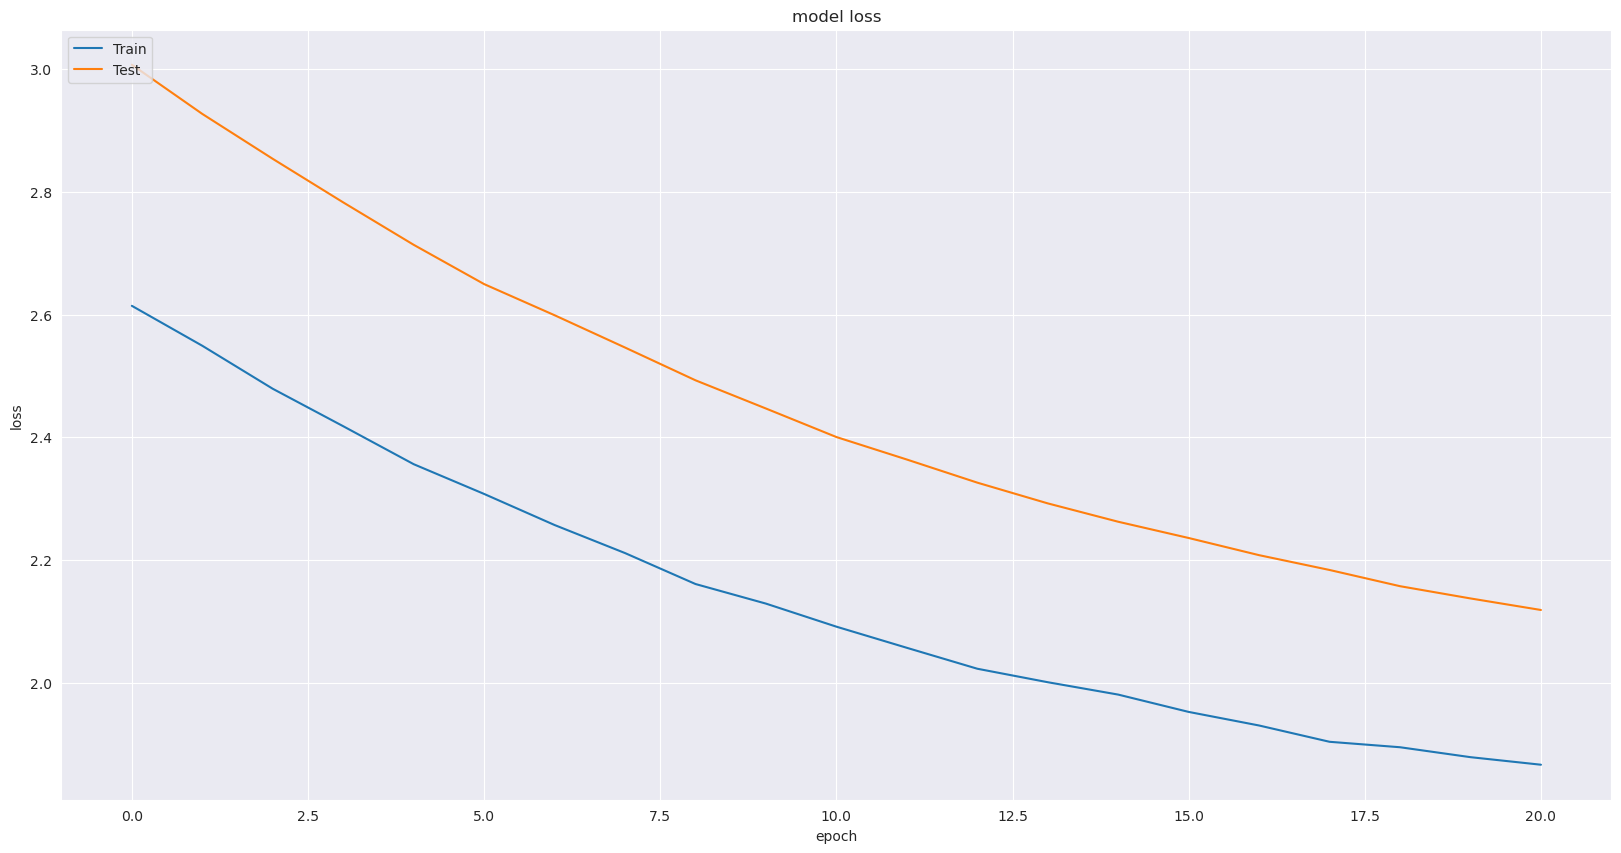

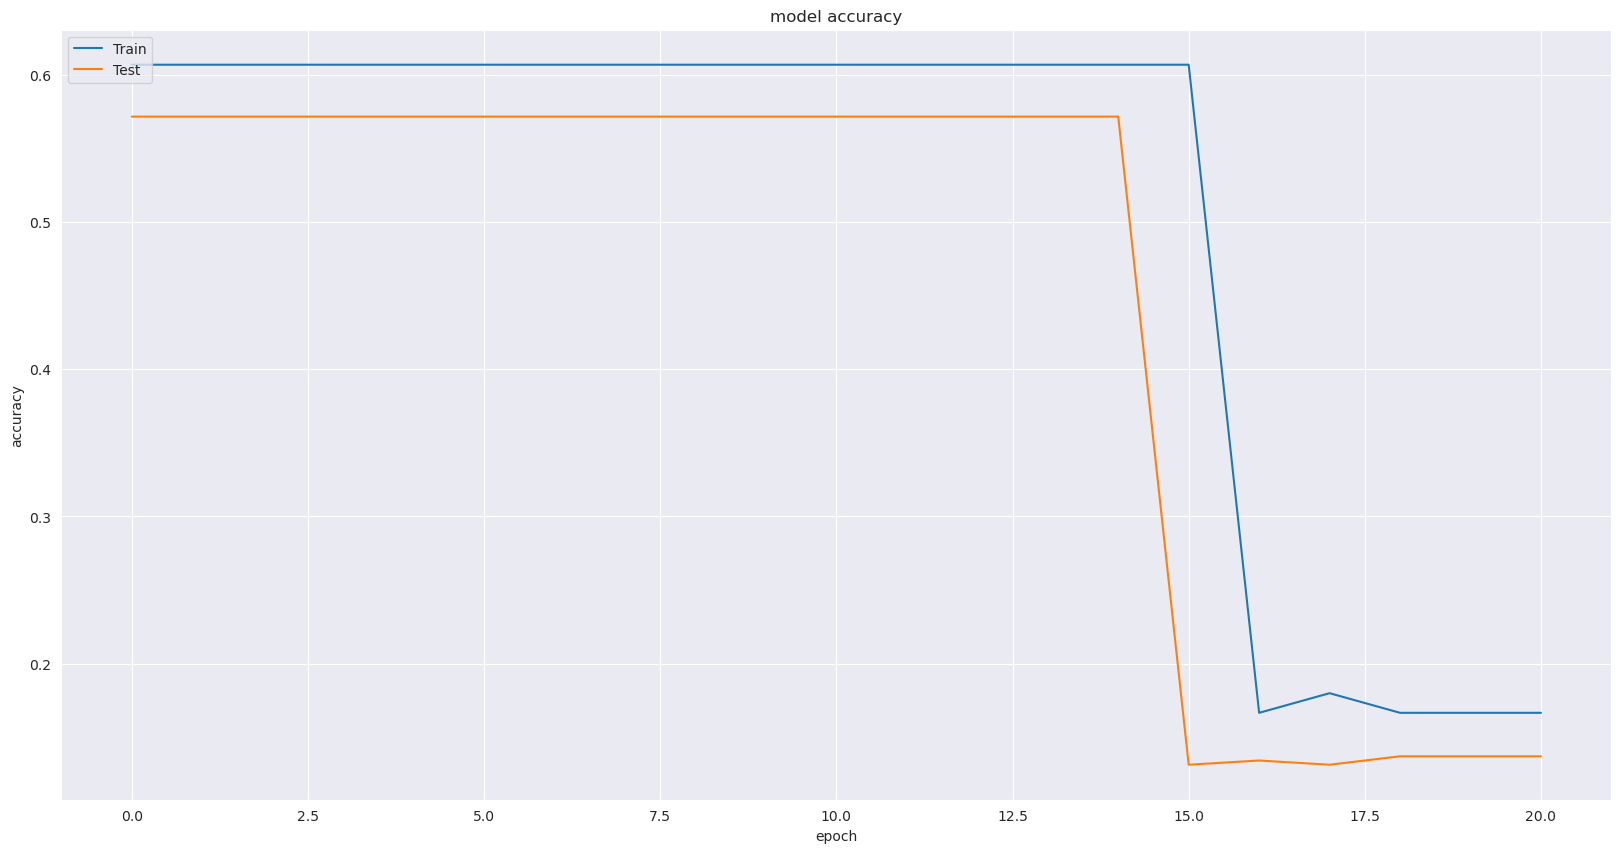

In [50]:
def my_plot(history):
    plt.figure(figsize=(20, 10))
    # plt.style.use("seaborn-paper")
    # summarize history for loss
    plt.plot(np.arange(len(history['training_loss'])),history['training_loss'])
    plt.plot(np.arange(len(history['training_loss'])),history['test_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
     # summarize history for accuracy
    plt.figure(figsize=(20, 10))
    plt.plot(np.arange(len(history['training_loss'])),history['training_acc'])
    plt.plot(np.arange(len(history['training_loss'])),history['test_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

my_plot(history)

In [1]:
def run_eval():
    with torch.no_grad():
        x = next(iter(eval_data_loader))
        x = x.unsqueeze(2)
        hidden = model.init_hidden(len(x)).to(device)
        preds, last_hidden = model(x.type(torch.float32), hidden)
        preds = preds.squeeze(1)
        preds = torch.round(preds)


        new_df = pd.DataFrame(preds)
        new_df.to_csv("brus_maj.csv", index=False)
run_eval()

NameError: name 'torch' is not defined